<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="https://raw.githubusercontent.com/DataForScience/Networks/master/data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Network Motifs</h1>
<h1>Frequent patterns in graphs</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm

import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 56e6b1910e1baf58fc77b56fb24eb35a9e2c2833

numpy     : 1.20.1
pandas    : 1.2.2
tqdm      : 4.50.2
json      : 2.0.9
networkx  : 2.5
watermark : 2.1.0
matplotlib: 3.3.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Toy Graph

Let us define the example graph as defined [here](https://ieeexplore.ieee.org/abstract/document/4015377)

In [4]:
G = nx.Graph()
G.add_edges_from(
[(1, 2),
 (1, 3),
 (1, 4),
 (1, 5),
 (2, 3),
 (2, 6),
 (2, 7),
 (3, 8),
 (3, 9),
])

In [5]:
pos = {
    1: (1, 1),
    2: (3, 1),
    3: (2, 2),
    4: (0, 1),
    5: (0, 0),
    6: (4, 0),
    7: (4, 1),
    8: (1, 3),
    9: (3, 3),   
}

We can now plot it

(-0.5, 3.5)

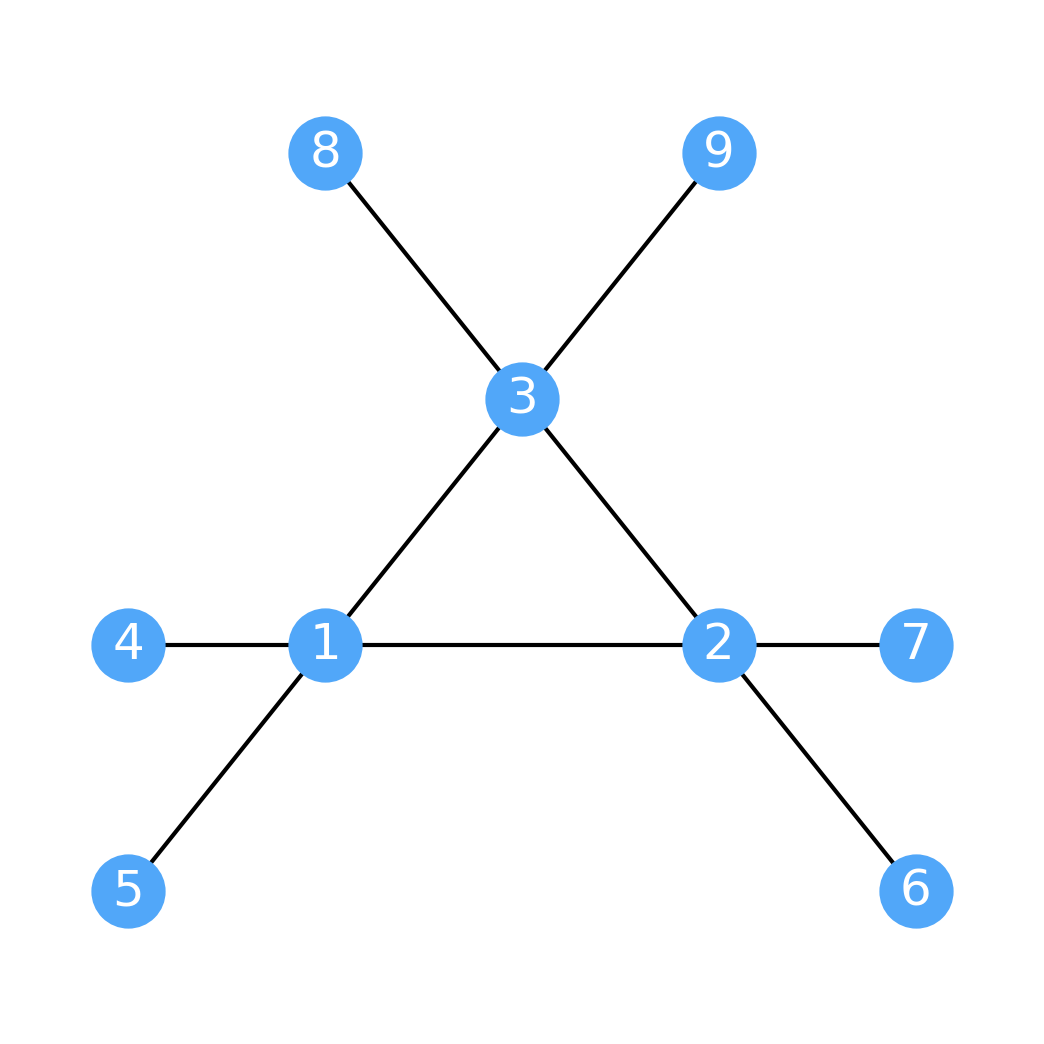

In [6]:
fig, ax = plt.subplots(1, figsize=(4,4))
nx.draw(G, pos=pos, node_color=colors[0], ax=ax)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)
ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.5, 3.5)

We start by defining an open neighbourhood as being all nodes that a set of nodes is connected to, other than themselves

In [7]:
def OpenNeighborhood(nodes, G):
    if type(nodes) == type(1) or type(nodes) == type('1'):
        nodes = set([nodes])
        
    neighborhood = set()

    for node in nodes:
        NN = set(G.neighbors(node))
        neighborhood.update(NN)

    return neighborhood - set(nodes)

So the open neighborhood of nodes {1, 3} is {3, 4, 5, 6, 7}

In [8]:
OpenNeighborhood({1, 2}, G)

{3, 4, 5, 6, 7}

We also introduce teh concept of an exclusive neighborhood of a node with respect to a set of nodes V as being the nodes that it is connected to except those in V or their neighbors

In [9]:
def ExclusiveNeighborhood(node_v, nodes, G):
    neighborhood = set()
    
    for node in nodes:
        NN = set(G.neighbors(node))
        neighborhood.update(NN)
    
    NN = set(G.neighbors(node_v))
    
    return NN-neighborhood

So the exclusive neighborhood of 1 wrt to 6 and 2 is

In [10]:
ExclusiveNeighborhood(1, {6, 2}, G)

{4, 5}

As we must exclude 2 and it's neighbor 3

Finally, we are able to implement the ESU algorithm as defined in Fig3

In [11]:
def EnumerateSubgraphs(G, k):
    graphs = []
    
    for v in G.nodes:
        Vext = {u for u in OpenNeighborhood(v, G) if u > v}
        graph = ExtendSubgraph({v}, Vext, v, k, G)
        
        if len(graph) > 0:
            graphs.extend(graph)
        
    return graphs

def ExtendSubgraph(Vsub, Vext, v, k, G):
    if len(Vsub) == k:
        return [nx.subgraph(G, Vsub)]
    
    graphs = []
    
    while len(Vext) != 0:
        w = Vext.pop()
        Vext2 = Vext | {u for u in ExclusiveNeighborhood(w, Vsub, G) if u > v}
        graph = ExtendSubgraph(Vsub | {w}, Vext2, v, k, G)
        
        if len(graph) > 0:
            graphs.extend(graph)
        
    return graphs

Applying this algorithm to our toy graph we obtain the 16 subgraphs enumerated in Fig4

In [12]:
graphs = EnumerateSubgraphs(G, 3)

Which we plot for ease of reference

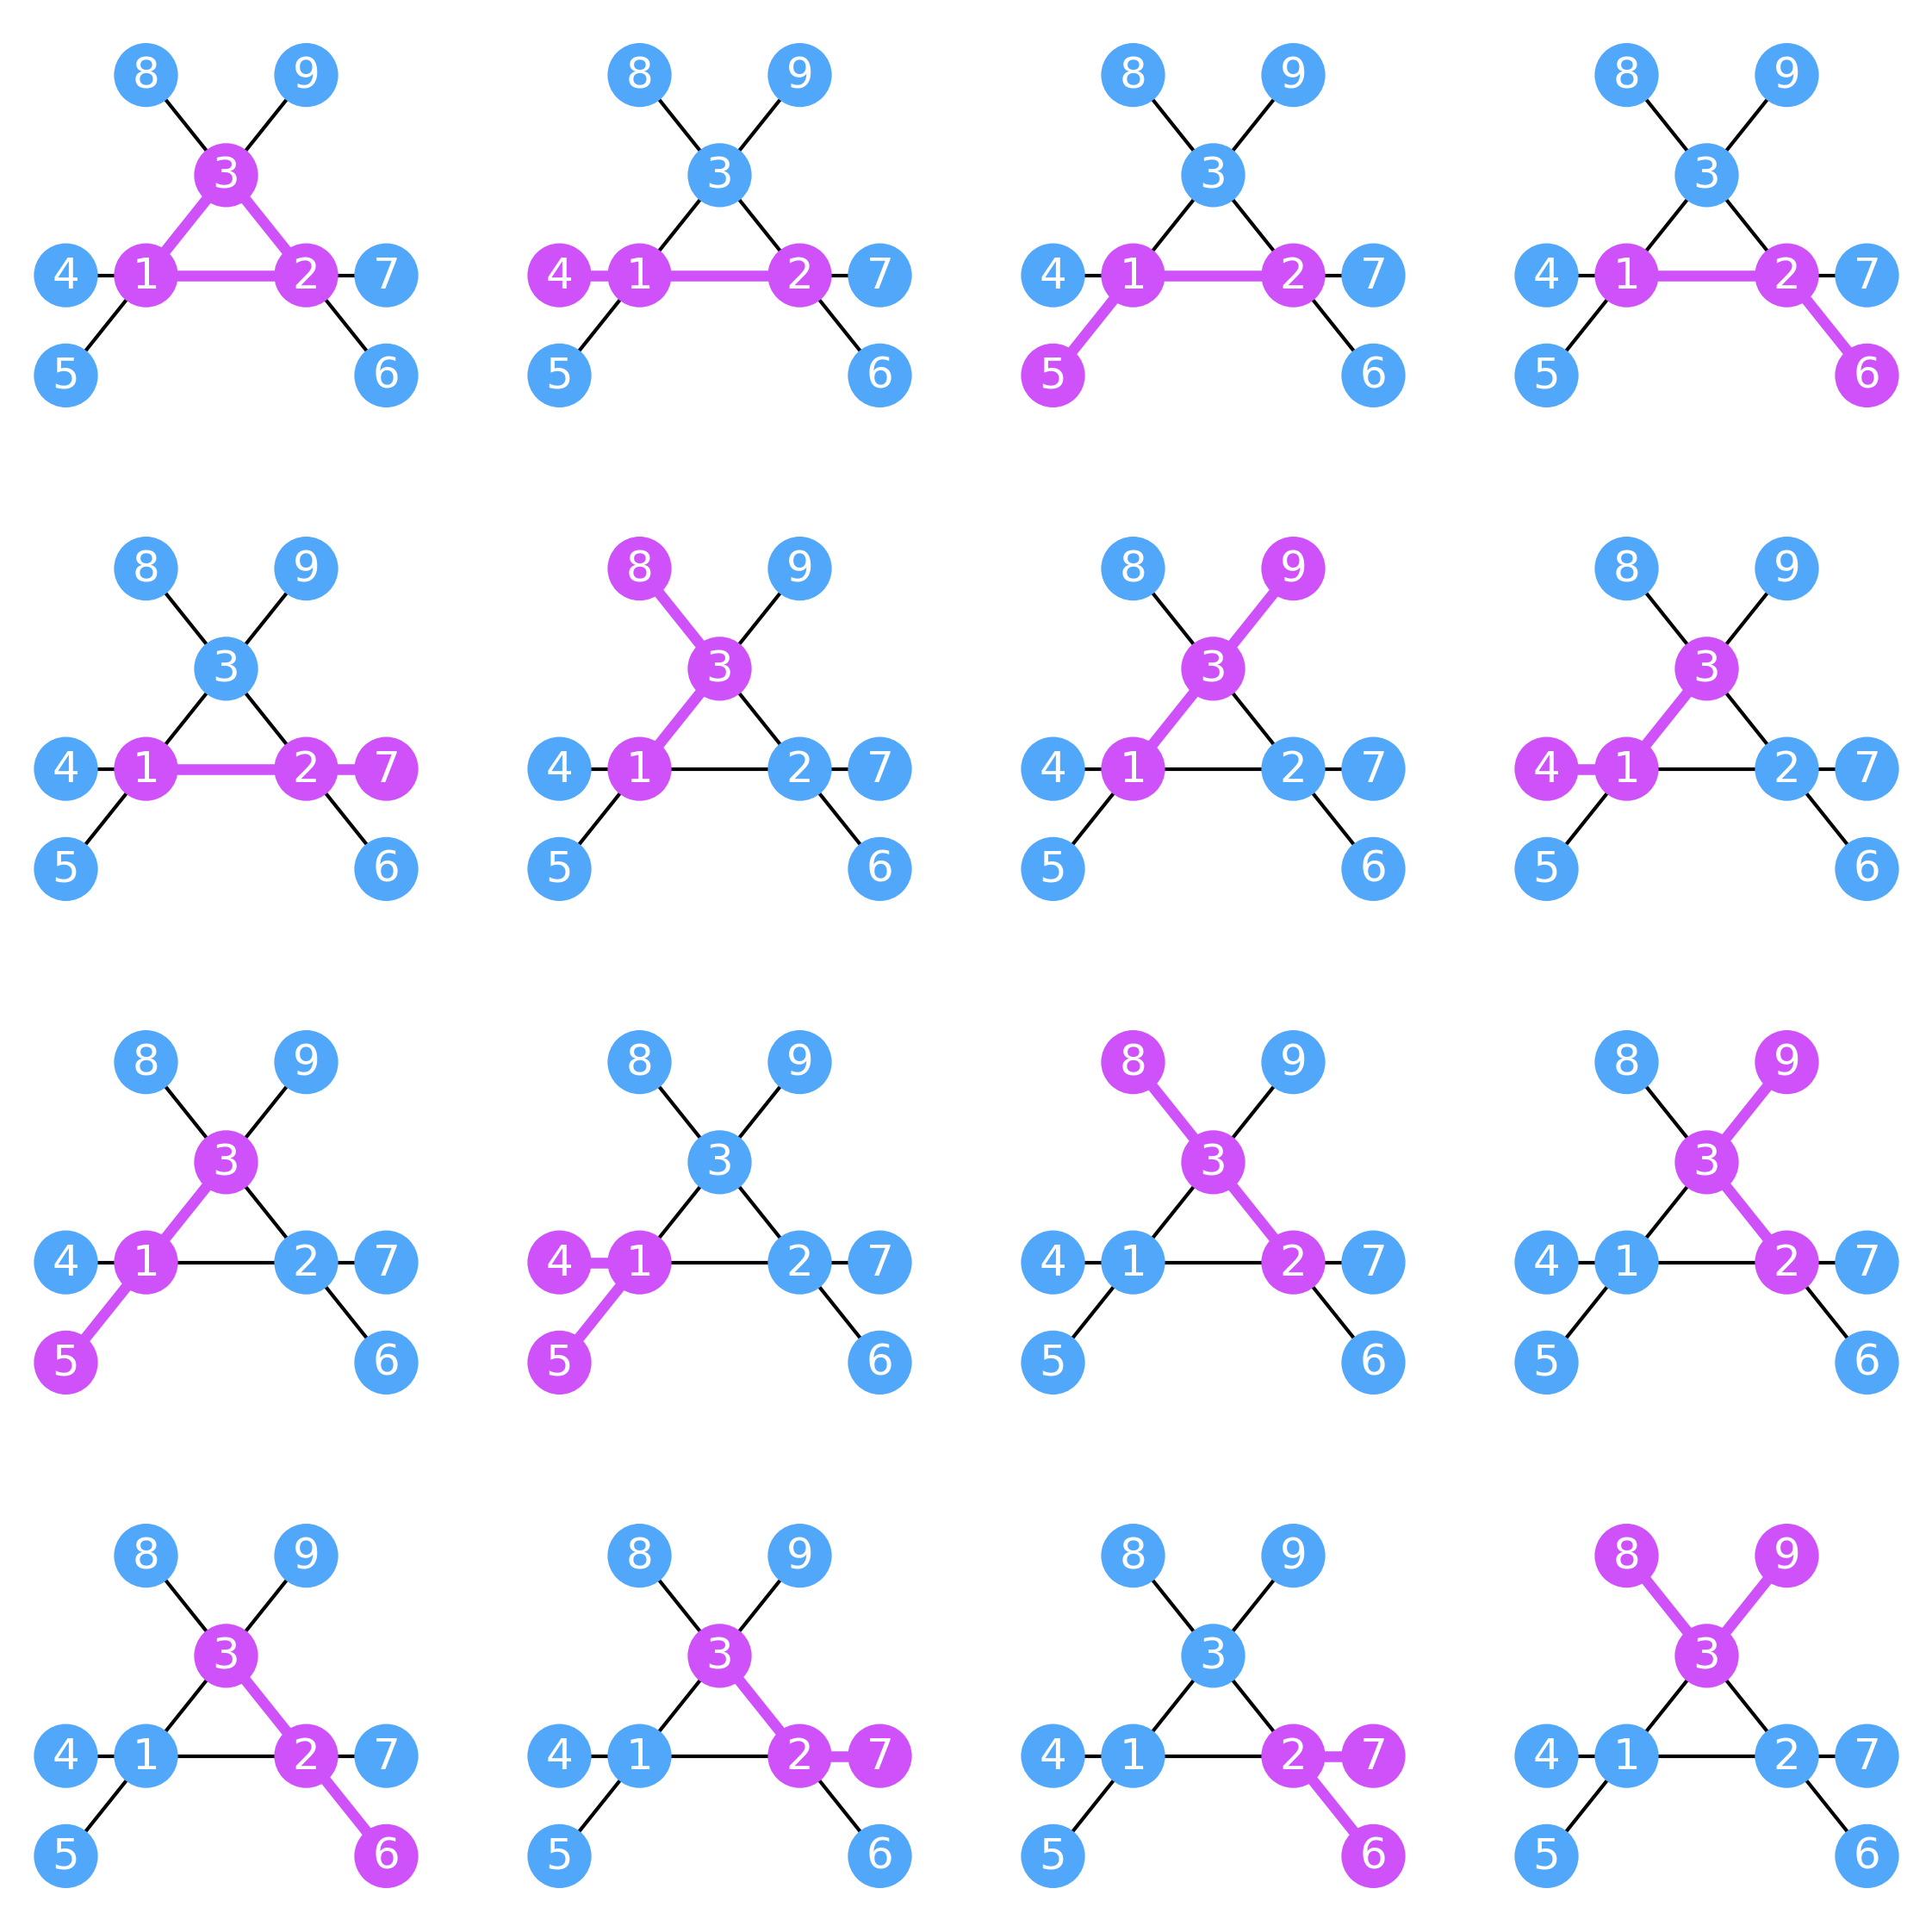

In [13]:
fig, ax_lst = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))
ax_lst = np.array(ax_lst).flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, graph in enumerate(graphs):
    node_color = [colors[0] if node not in graph.nodes() else colors[1] for node in G.nodes()]
    
    nx.draw(G, pos=pos, ax=ax_lst[i], node_color=node_color)
    nx.draw_networkx_labels(G, pos=pos, ax=ax_lst[i], font_color='white')
    nx.draw_networkx_edges(graph, pos=pos, ax=ax_lst[i], edge_color=colors[1], width=3)

    ax_lst[i].set_ylim(-0.5, 3.5)
    ax_lst[i].set_xlim(-0.5, 4.5)
    
fig.tight_layout()

Finally, we introduce a simple function to count the popularity of each motif. This function simply enumerates all the unique isomorphic subgraphs (graphs that differ only by the labels of the nodes) 

In [14]:
def CountMotifs(graphs):
    counts = {}

    for graph in graphs:
        if len(counts) == 0:
            counts[graph] = 1
        else:
            match = False

            for g in counts:
                if nx.is_isomorphic(graph, g):
                    counts[g] += 1
                    match = True
                    break

            if not match:
                counts[graph] = 1
                
    return counts

In our set 16 subgraphs, we see that there are only two motifs, one with 3 edges (a triangle) that appears only once and one with 2 edges that accounts for the remaining 15 subgraphs

In [15]:
counts = CountMotifs(graphs)
counts

{<networkx.classes.graph.Graph at 0x7f8e494be910>: 1,
 <networkx.classes.graph.Graph at 0x7f8e494beeb0>: 15}

Which we plot side by side

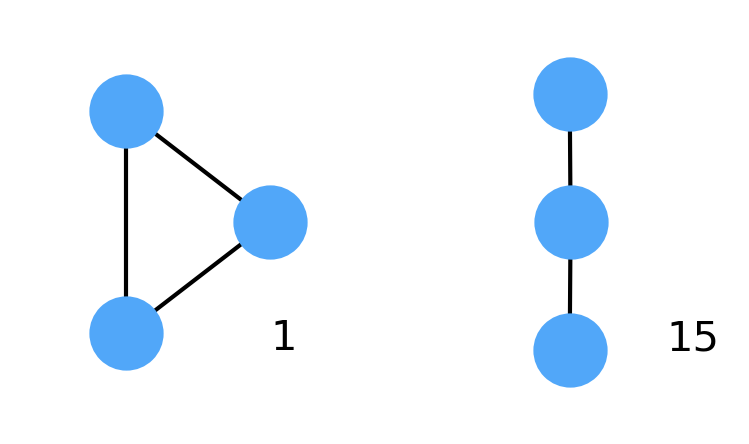

In [16]:
fig, ax_lst = plt.subplots(1, 2, figsize=(3, 2))
ax_lst = np.array(ax_lst).flatten()

for i, g in enumerate(counts.keys()):
    gpos = nx.layout.kamada_kawai_layout(g)
    gpos = nx.layout.rescale_layout_dict(gpos)
    nx.draw(g, ax=ax_lst[i], pos=gpos, node_color=colors[0])

    ax_lst[i].set_ylim(-1.5, 1.5)
    ax_lst[i].set_xlim(-1.5, 1.5) 
    
    ax_lst[i].text(1, -1, counts[g], fontsize=10)

for i in range(len(counts), len(ax_lst)):
    ax_lst[i].axis('off')

Where the number next to each motif corresponds to the frequency with which it occurs

# Directed Graphs

To check that our algorithm also works for directe graphs, we define a toy directed graph

In [17]:
G = nx.DiGraph()
G.add_edges_from([
    (1,2),
    (1,3),
    (1,4),
    (2,3),
    (2,4),
    (3,4),
    (3,5),
    (4,5),
])

Our graph now looks slightly different

In [18]:
pos = nx.layout.planar_layout(G)

{1: Text(-0.17647058823529416, -0.0588235294117647, '1'),
 2: Text(-0.7647058823529412, -0.35294117647058826, '2'),
 3: Text(1.0, -0.35294117647058826, '3'),
 4: Text(-0.17647058823529416, 0.23529411764705885, '4'),
 5: Text(0.1176470588235294, 0.5294117647058824, '5')}

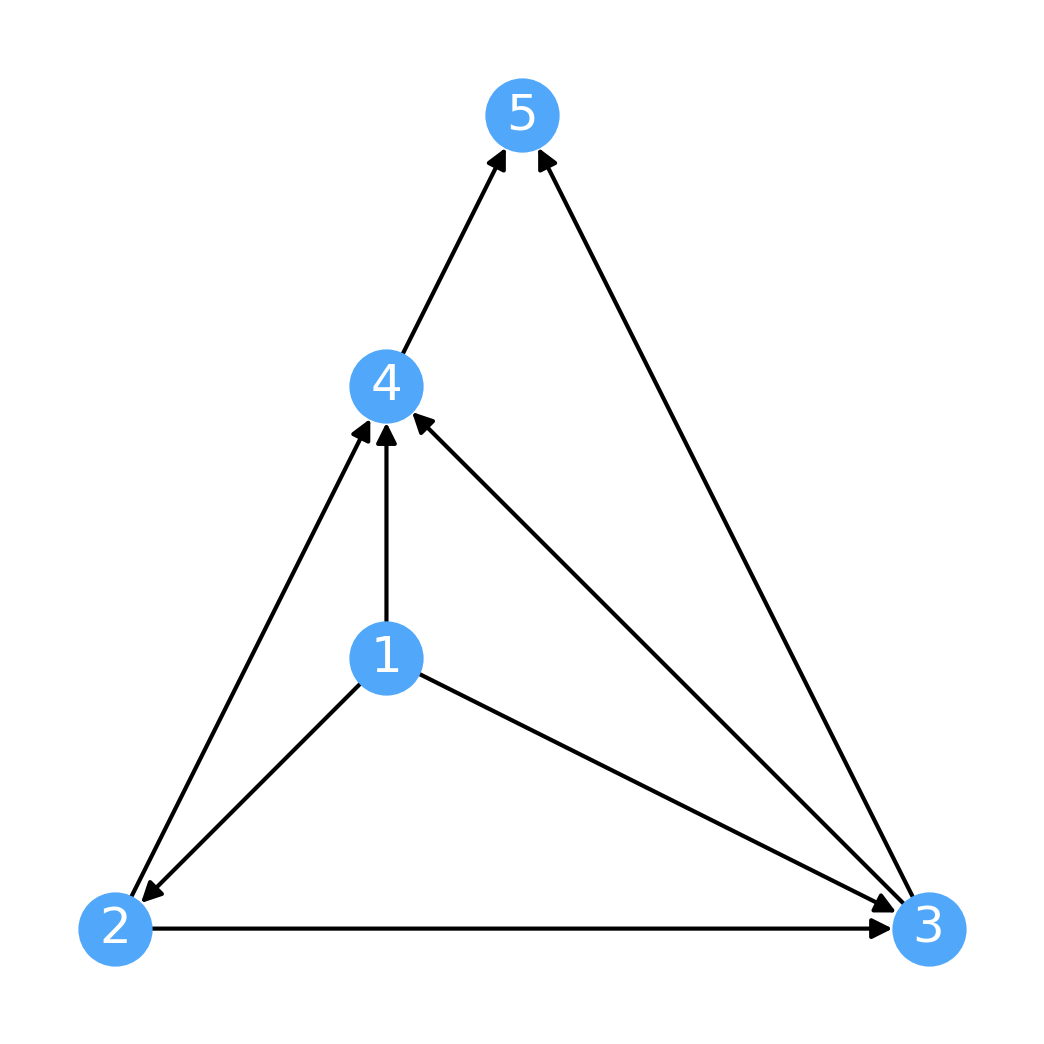

In [19]:
fig, ax = plt.subplots(1, figsize=(4,4))
nx.draw(G, pos=pos, node_color=colors[0], ax=ax)
nx.draw_networkx_labels(G, pos=pos, font_color='white', ax=ax)

We find a set of 9 subgraphs

In [20]:
graphs = EnumerateSubgraphs(G, 3)
len(graphs)

9

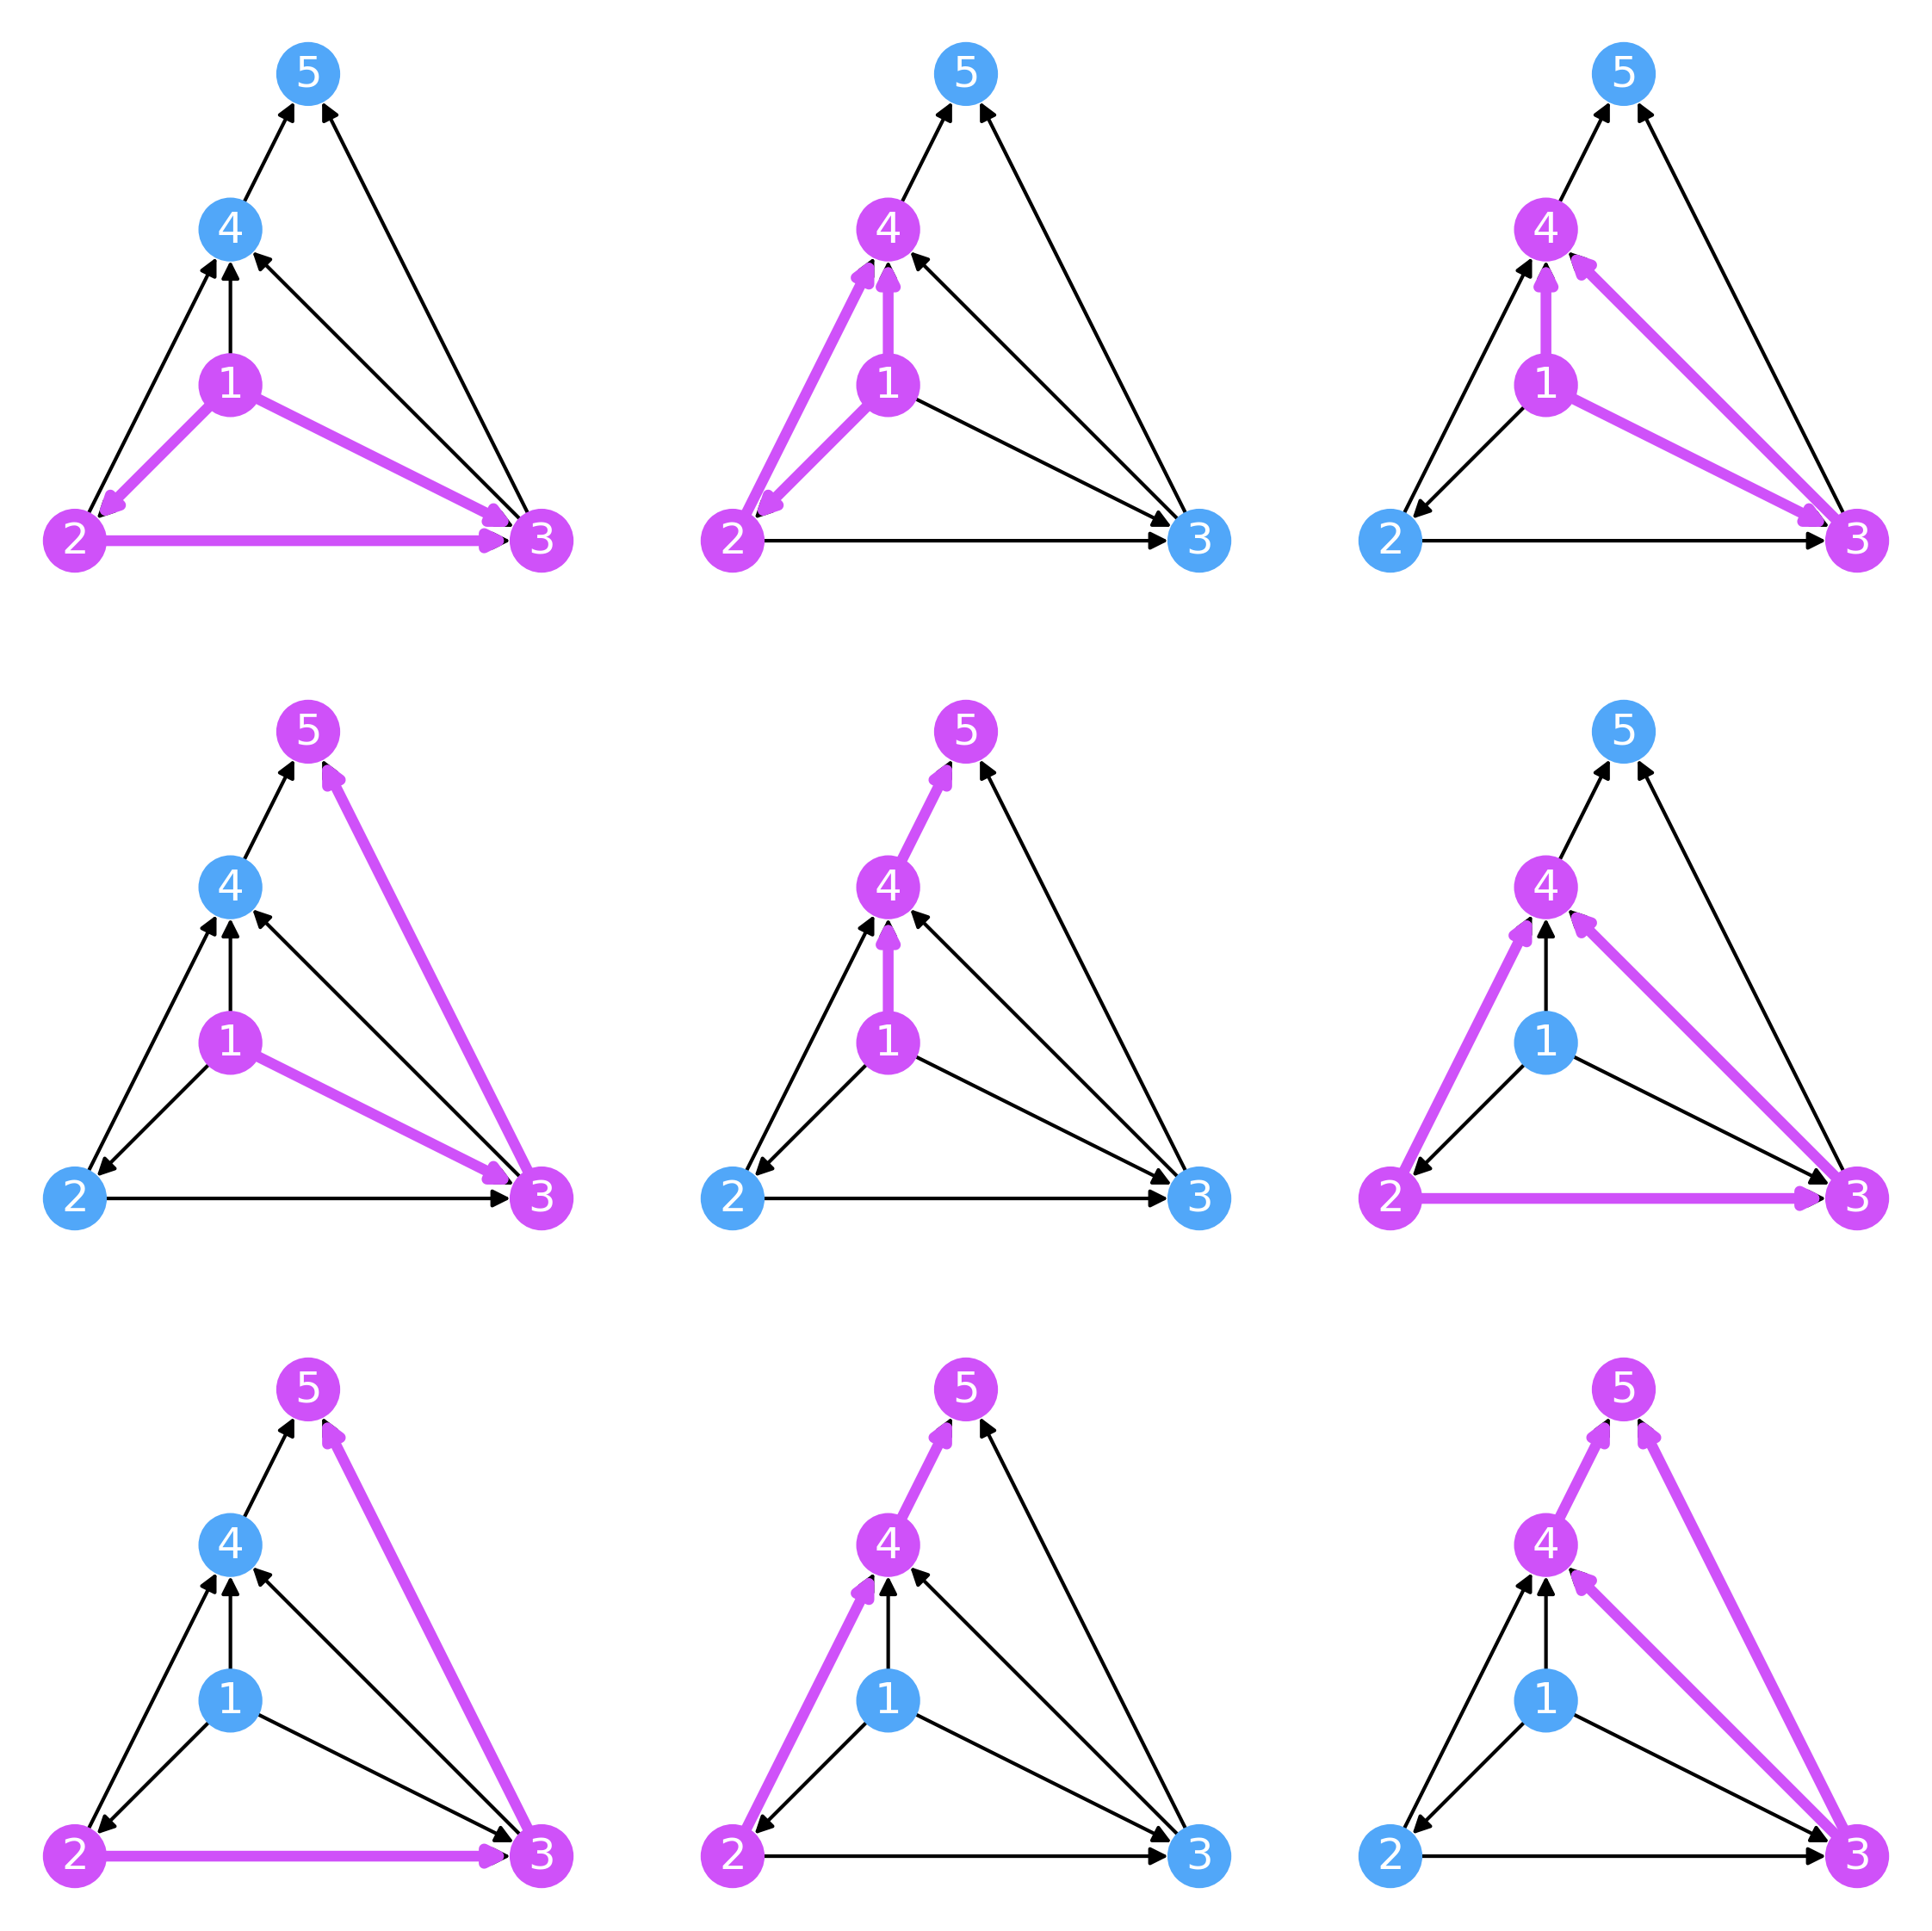

In [21]:
fig, ax_lst = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 8))
ax_lst = np.array(ax_lst).flatten()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i, graph in enumerate(graphs):
    node_color = [colors[0] if node not in graph.nodes() 
                  else colors[1] for node in G.nodes()]
    
    nx.draw(G, pos=pos, ax=ax_lst[i], node_color=node_color)
    nx.draw_networkx_labels(G, pos=pos, ax=ax_lst[i], font_color='white')
    nx.draw_networkx_edges(graph, pos=pos, ax=ax_lst[i], 
                           edge_color=colors[1], width=3)
    
fig.tight_layout()

But now we have only 2 different motifs

In [22]:
counts = CountMotifs(graphs)
counts

{<networkx.classes.digraph.DiGraph at 0x7f8e38846fa0>: 5,
 <networkx.classes.digraph.DiGraph at 0x7f8e38852790>: 4}

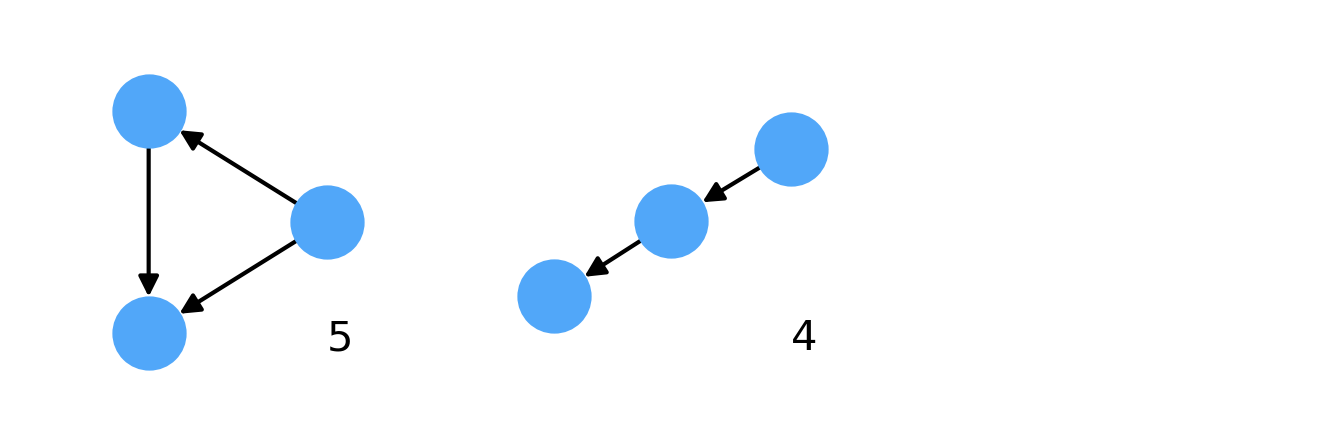

In [23]:
fig, ax_lst = plt.subplots(1, 3, figsize=(5, 2))
ax_lst = np.array(ax_lst).flatten()

for i, g in enumerate(counts.keys()):
    gpos = nx.layout.kamada_kawai_layout(g)
    gpos = nx.layout.rescale_layout_dict(gpos)
    nx.draw(g, ax=ax_lst[i], pos=gpos, node_color=colors[0])

    ax_lst[i].set_ylim(-1.5, 1.5)
    ax_lst[i].set_xlim(-1.5, 1.5) 
    
    ax_lst[i].text(1, -1, counts[g], fontsize=10)

for i in range(len(counts), len(ax_lst)):
    ax_lst[i].axis('off')

# Higgs Strongest Connected Component

We load the SCC of the higgs boson announcement twitter reply graph we extracted previously (see Components.ipynb). For the sake of simplificy we remove all self loops

In [24]:
SCC = nx.read_edgelist('data/higgs_SCC.dat.gz', create_using=nx.DiGraph)
SCC.remove_edges_from(nx.selfloop_edges(SCC))

And plot it

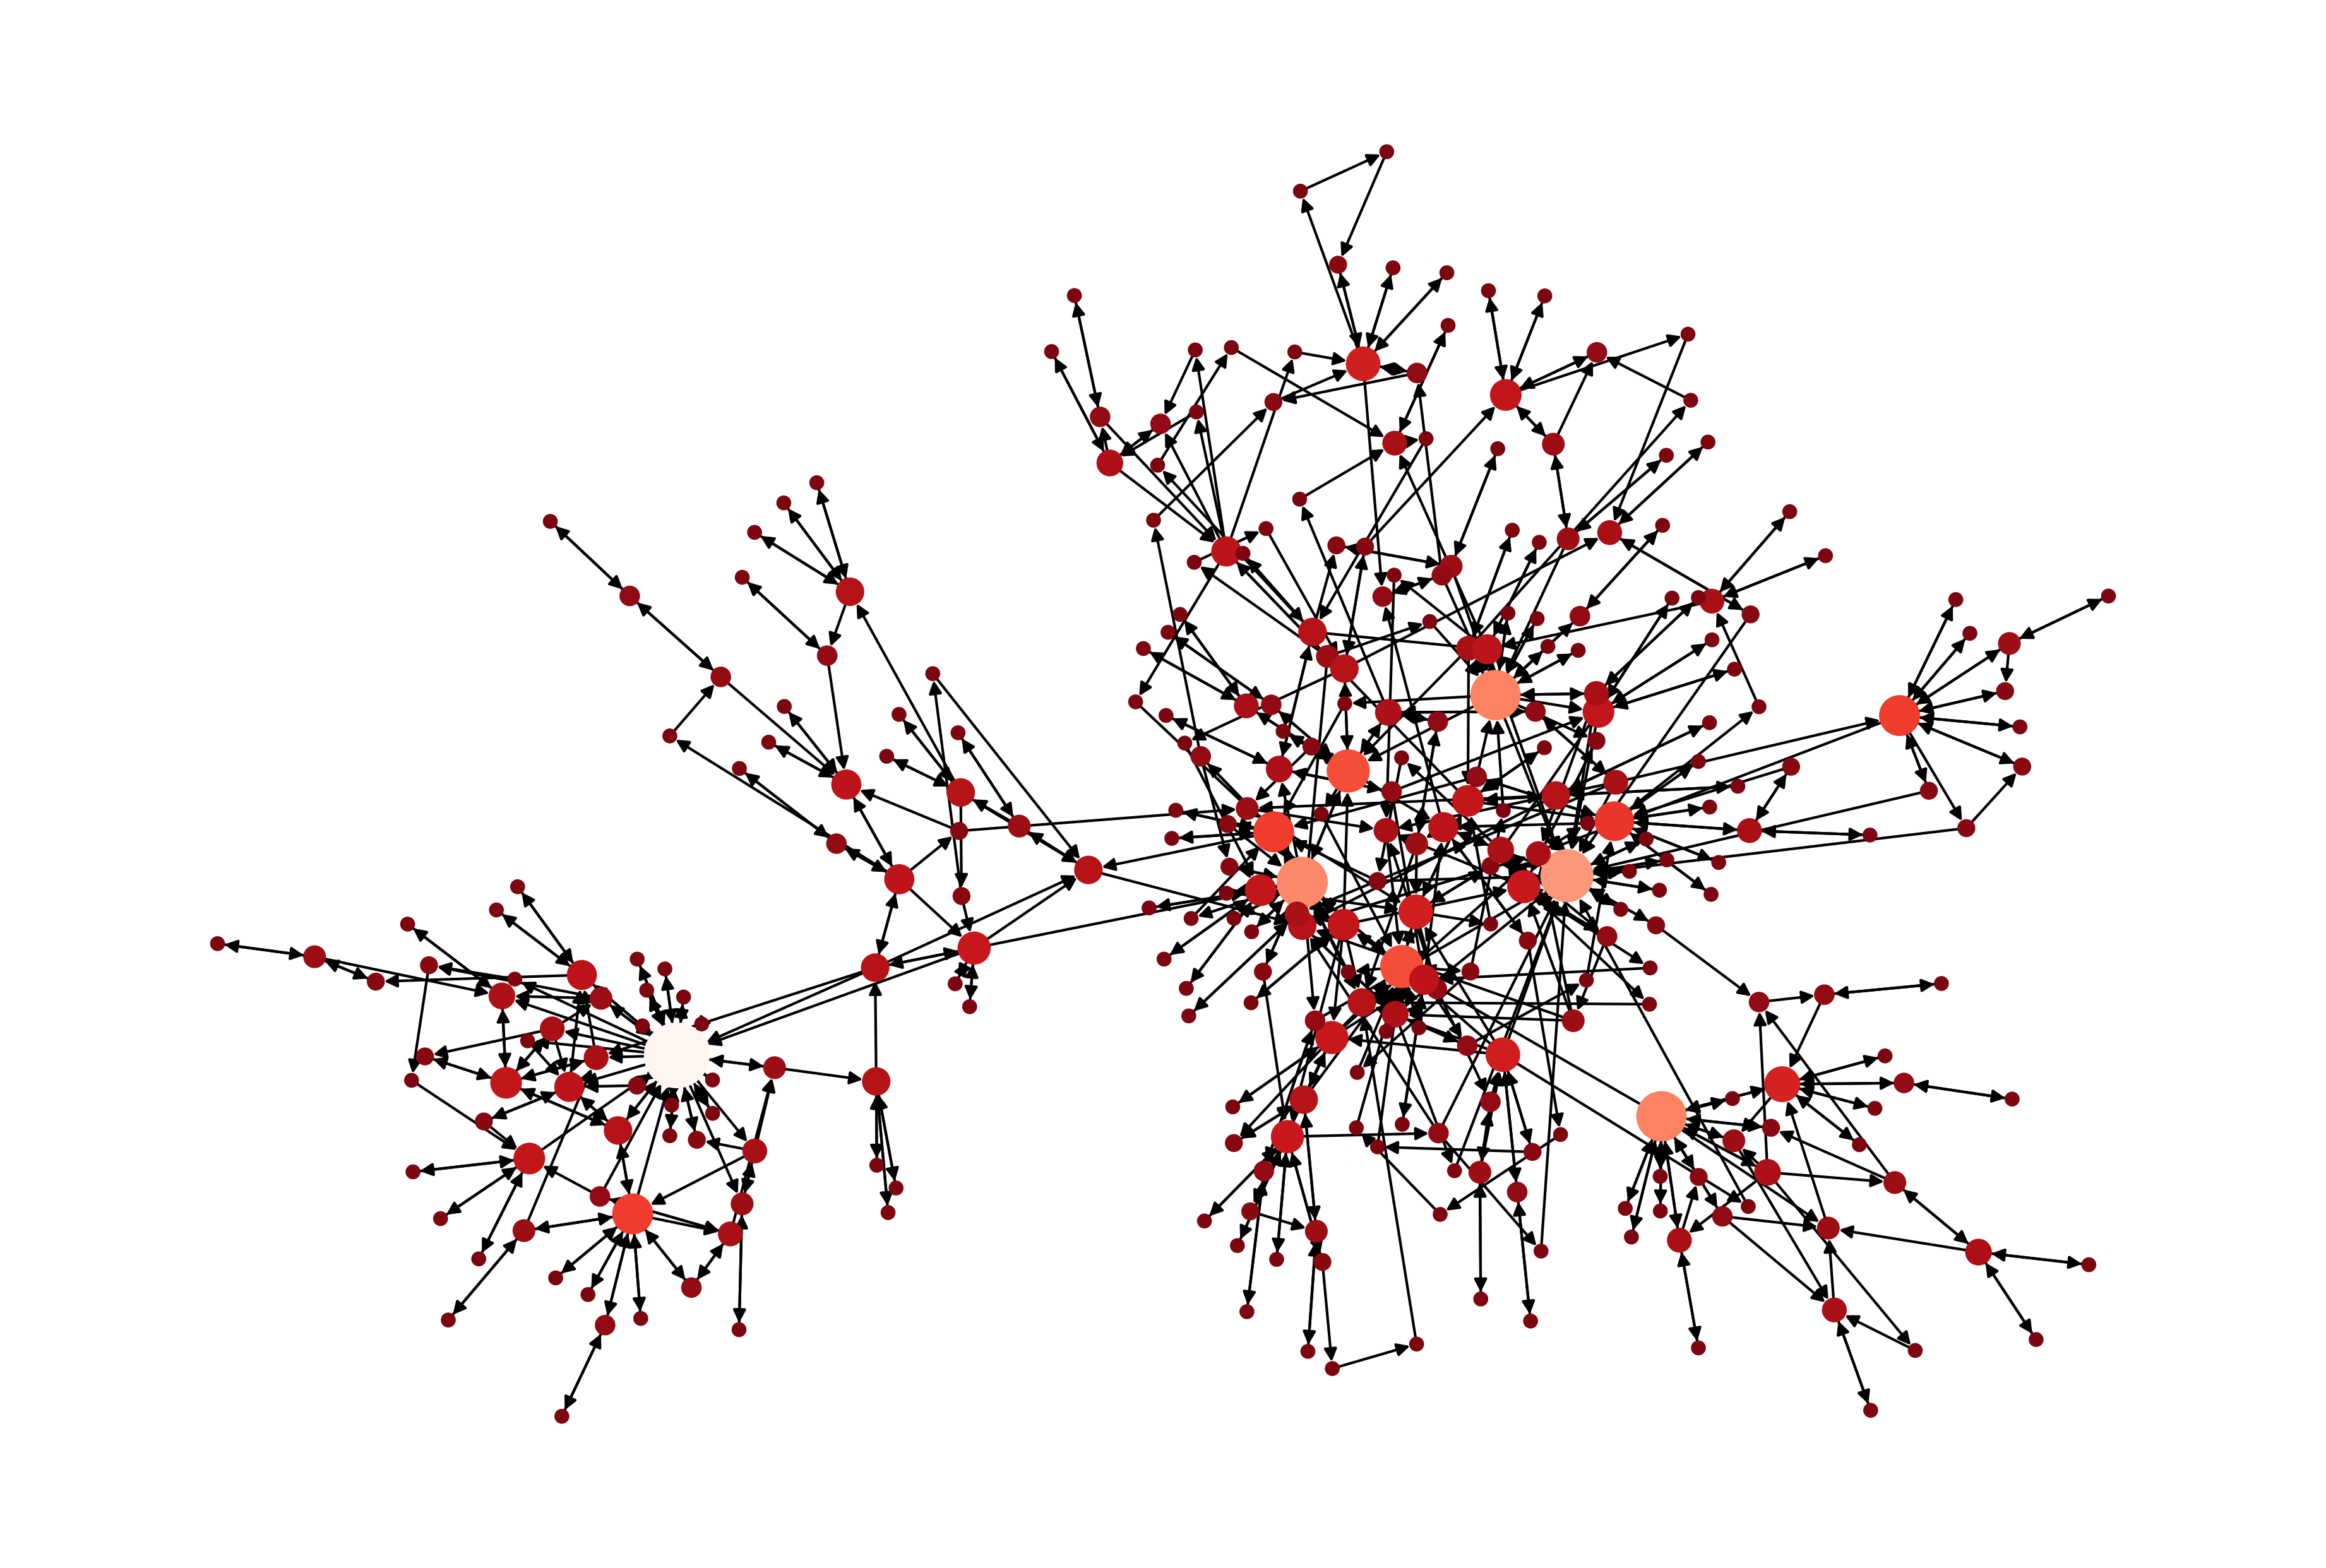

In [25]:
np.random.seed(42)
random.seed(42)
SCC_pos = nx.layout.kamada_kawai_layout(SCC)

degrees = dict(SCC.degree())
max_degree = np.max(list(degrees.values()))

sizes = []
SCC_colors = []
for node in SCC.nodes:
    degree = degrees[node]
    sizes.append( degree/ max_degree * 600)
    SCC_colors.append(plt.cm.Reds_r(degree / max_degree))
    
nx.draw_networkx_edges(SCC, pos=SCC_pos, node_size=sizes)
nx.draw_networkx_nodes(SCC, pos=SCC_pos, node_size=sizes, 
                       node_color=SCC_colors)
plt.gca().axis('off');

Now we enumerate all subgraphs with 3 nodes

In [26]:
graphs = EnumerateSubgraphs(SCC, 3)

There's over 1200 of them!

In [27]:
len(graphs)

1240

Which can be neatly grouped into just 11 motifs

In [28]:
counts = CountMotifs(graphs)

In [29]:
counts

{<networkx.classes.digraph.DiGraph at 0x7f8e2854f790>: 491,
 <networkx.classes.digraph.DiGraph at 0x7f8e28583670>: 321,
 <networkx.classes.digraph.DiGraph at 0x7f8e48be71f0>: 193,
 <networkx.classes.digraph.DiGraph at 0x7f8e48be7a00>: 41,
 <networkx.classes.digraph.DiGraph at 0x7f8e2854ad30>: 16,
 <networkx.classes.digraph.DiGraph at 0x7f8e182fe940>: 149,
 <networkx.classes.digraph.DiGraph at 0x7f8e2844b490>: 6,
 <networkx.classes.digraph.DiGraph at 0x7f8e494c4a60>: 15,
 <networkx.classes.digraph.DiGraph at 0x7f8e181a6a60>: 4,
 <networkx.classes.digraph.DiGraph at 0x7f8e59086970>: 3,
 <networkx.classes.digraph.DiGraph at 0x7f8e28565250>: 1}

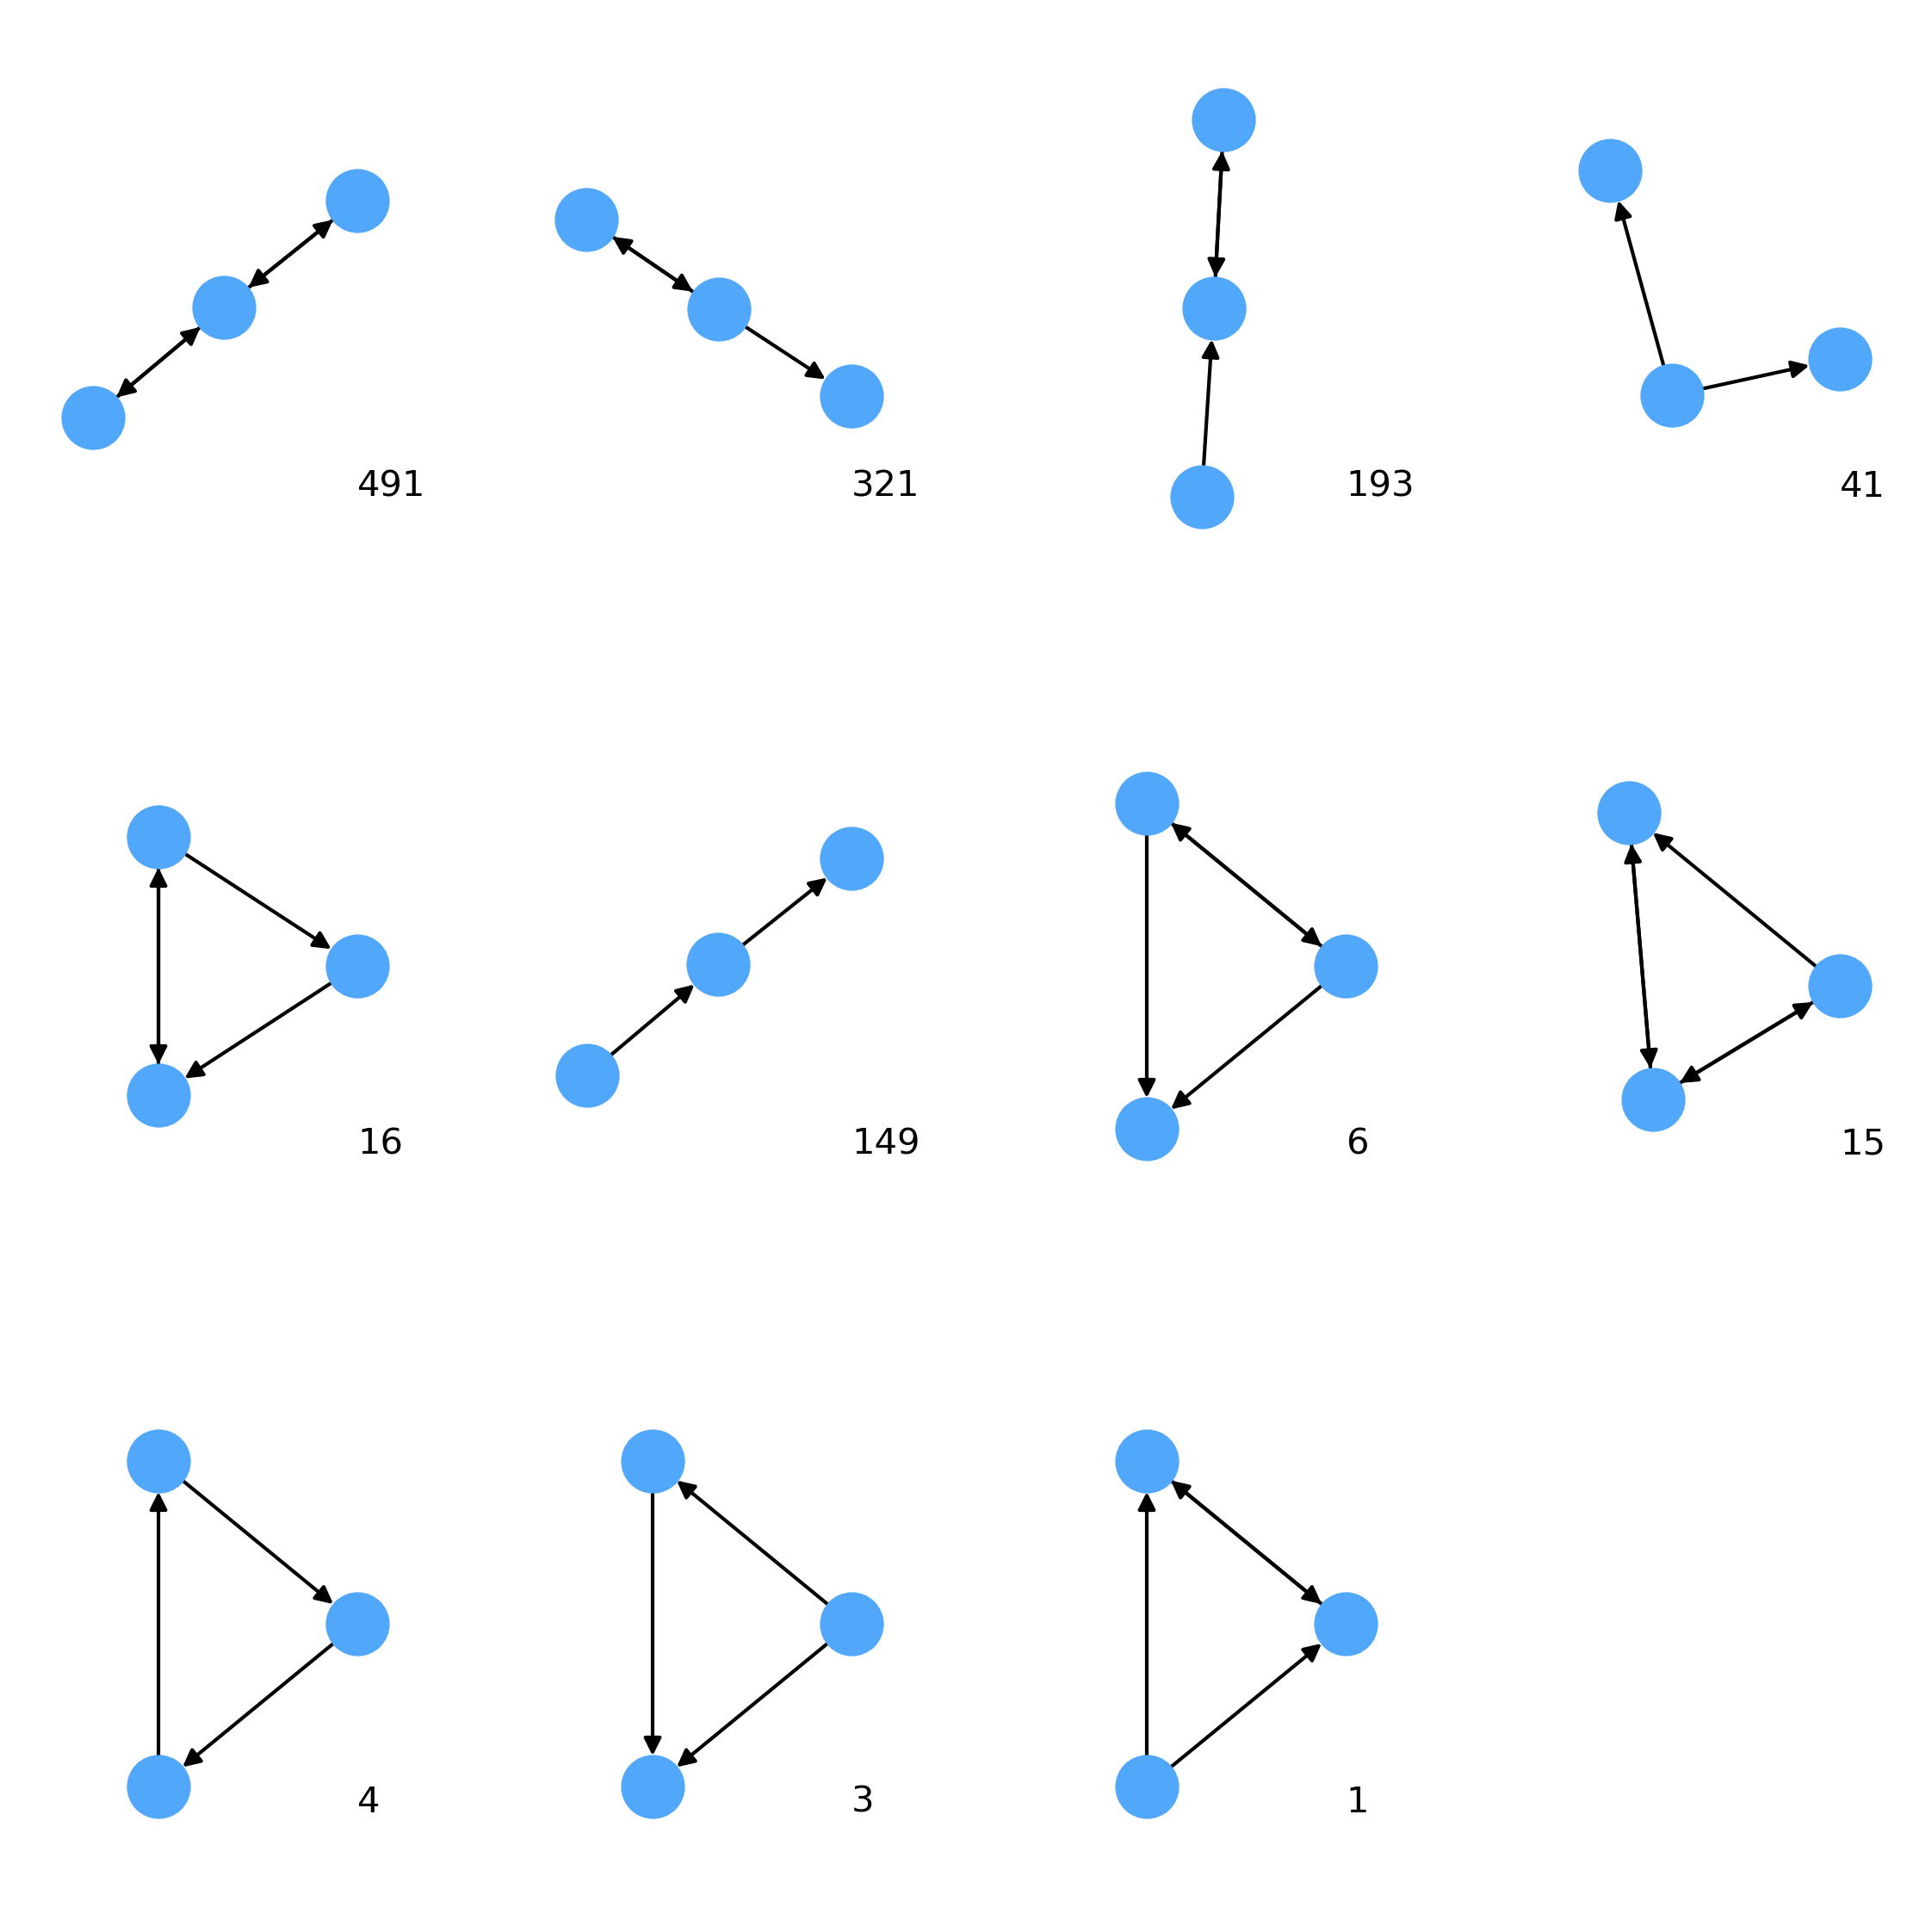

In [30]:
fig, ax_lst = plt.subplots(3, 4, figsize=(8, 8))
ax_lst = np.array(ax_lst).flatten()

for i, g in enumerate(counts.keys()):
    pos = nx.layout.kamada_kawai_layout(g)
    pos = nx.layout.rescale_layout_dict(pos)
    nx.draw(g, ax=ax_lst[i], pos=pos, node_color=colors[0])
    
    ax_lst[i].set_ylim(-1.5, 1.5)
    ax_lst[i].set_xlim(-1.5, 1.5) 
    
    ax_lst[i].text(1, -1, counts[g], fontsize=10)
    
for i in range(len(counts), len(ax_lst)):
    ax_lst[i].axis('off')

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>